#  MACHINE LEARNING: Portugal Wine. Two Class approach for Quality classification with Neural Network using R


By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | November 04, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

# I Introduction

This project develops neural Network algorithm of machine learning to classifythe quality of the wine "Good" or "Bad" according to 12 variables that characterize the wine subject to classification. I use nnet R library with a linout default option to get a logistic output.

I use the famous Portugal wine dataset. Two datasets are available of which one dataset is about red wine and have 1599 different varieties and the other is on white wine and have 4898 varieties. I have combined them into one dataset named "wine" and created one additional variable "Class" with its categories "white" and "red". After that, I re-coded the "quality" variable to indicate scores greater than or equal to 6 (denoted as "Good") or to indicate scores smaller than 6(denoted as "Bad").

The original data along with detailed description can be found here [ http://archive.ics.uci.edu/ml/datasets/Wine+Quality].

The columns of the "wine" dataset are the variables (features): fixed acidity; volatile acidity; citric acid; residual sugar; chlorides; free sulfur dioxide; total sulfur dioxide; density; pH; sulphates; alcohol; quality. The 13th column is the Class of wine observed: white; red.

Our original dataset is an imbalance one. There are 6497 registers but only 1599 (24.6%) are of the red class of wine.

I consider the original dataset without the variables "density" and "free.sulfor.dioxide". I get rid of them because they could generate a problem of multicollinearity in the process of classification.

The dataset (dfffull) keep all the register of the original database but replace the upper outliers by its corresponding <i>Threshold</i>.

I consider outliers those points that have any predictor variable value to be outside of the limits constructed by boxplots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule does not reduces the original datasize becouse it does not eliminate any register.  So, <i>dfffull</i> data size is the same as the original (6497 registers).

The model performance is evaluated using R, K fold cross-validation, and the ROC metric. I consider 70% and 30% original dataset splitting for the training and testing datasets respectively.

# II Loading, EDA and Data Preprocessing

## 21 Loading the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [1]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "NeuralNetTools", "car","caret")
ipak(packages)


Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: NeuralNetTools
Warning message:
"package 'NeuralNetTools' was built under R version 3.4.2"Loading required package: car
Warning message:
"package 'car' was built under R version 3.4.2"
Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


plyr          dplyr NeuralNetTools            car          caret 
          TRUE           TRUE           TRUE           TRUE           TRUE

In [2]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
wine <- rbind(cbind(wine1, Class='white'), cbind(wine2, Class='red'))
wine$quality<- ifelse(wine$quality>=6, "Good", ifelse(wine$quality<6, "Bad", NA))

df= subset(wine, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'Class'))
attach(df)
head(df)
rm("wine", "wine1", "wine2")

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,Good,white
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,Good,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,Good,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,Good,white


In [3]:
# verify response variable "quality" as factor
df$quality <- as.factor(df$quality)
df$Class <- as.factor(df$Class)

In [4]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [5]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}

In [6]:
# summarize original df dataset
(summary1=propmiss(df[,-c(10:11)])[,-(3:4)])

variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19


In [7]:
# r code to replace outliers by the threshold of each variable
library(mlr)

Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [8]:
dfffull <- capLargeValues(df, target = "quality",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "quality",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")

In [9]:
# get some information about the dataset
str(dfffull)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [10]:
# remove and dettach df dataset
rm("df")
detach("df")

In [11]:
# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [12]:
head(df)
str(df)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white
6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,Good,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


## 22 Exploratory Data Analysis (EDA) and Data Preprocessing

This Exploratory Data Analysis and Data Preprocessing unit has been done in another project already. The results and the R code [can be found here ](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Portugal_Wine_TwoClass_RedWhite_R_KFold/Project4_Portugal_WINE_TwoClass_EDA.ipynb).

# III Getting train and test datasets

In [13]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$quality ,  p = 0.70, list = F)
testing <- df[-data_part,] # 30% data goes here
training <- df[data_part,] # 70% here

In [14]:
#taking a look of the train and test dataset by columns 
head(training)
head(testing)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
2,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,Good,white
3,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white
4,7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
5,7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
8,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white
9,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,Good,white


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
1,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white
6,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white
7,6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,Good,white
11,8.1,0.27,0.41,1.45,0.033,63,2.99,0.56,12.0,Bad,white
12,8.6,0.23,0.40,4.20,0.035,109,3.14,0.53,9.7,Bad,white
19,7.4,0.34,0.42,1.10,0.033,171,3.12,0.53,11.3,Good,white


In [15]:
# get some information about training dataset
str(training[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 8.1 7.2 7.2 7 6.3 8.1 7.9 6.6 8.3 ...
 $ volatile.acidity    : num  0.3 0.28 0.23 0.23 0.27 0.3 0.22 0.18 0.16 0.42 ...
 $ citric.acid         : num  0.34 0.4 0.32 0.32 0.36 0.34 0.43 0.37 0.4 0.6 ...
 $ residual.sugar      : num  1.6 6.9 8.5 8.5 17.5 ...
 $ chlorides           : num  0.049 0.05 0.058 0.058 0.045 0.049 0.044 0.04 0.044 0.04 ...
 $ total.sulfur.dioxide: num  132 97 186 186 170 132 129 75 143 172 ...
 $ pH                  : num  3.3 3.26 3.19 3.19 3 3.3 3.22 3.18 3.54 2.98 ...
 $ sulphates           : num  0.49 0.44 0.4 0.4 0.45 0.49 0.45 0.63 0.52 0.67 ...
 $ alcohol             : num  9.5 10.1 9.9 9.9 8.8 9.5 11 10.8 12.4 9.7 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 1 2 1 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [16]:
# get some information about testing dataset
str(testing[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 8.1 6.2 8.1 8.6 7.4 6.5 7 7.4 8.5 ...
 $ volatile.acidity    : num  0.27 0.28 0.32 0.27 0.23 0.34 0.31 0.25 0.27 0.24 ...
 $ citric.acid         : num  0.36 0.4 0.16 0.41 0.4 0.42 0.14 0.32 0.48 0.39 ...
 $ residual.sugar      : num  17.55 6.9 7 1.45 4.2 ...
 $ chlorides           : num  0.045 0.05 0.045 0.033 0.035 0.033 0.044 0.046 0.047 0.044 ...
 $ total.sulfur.dioxide: num  170 97 136 63 109 171 133 245 132 142 ...
 $ pH                  : num  3 3.26 3.18 2.99 3.14 3.12 3.22 3.25 3.19 3.2 ...
 $ sulphates           : num  0.45 0.44 0.47 0.56 0.53 0.53 0.5 0.5 0.49 0.53 ...
 $ alcohol             : num  8.8 10.1 9.6 12 9.7 11.3 9.5 10.4 11.6 10 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 1 1 2 1 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [17]:
# summarize training dataset
(summary=propmiss(training[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.70,1.30,3.80,7.00,9.65,5.85,7.15,1.07
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.29,0.66,0.58,0.33,0.15
citric.acid,4549,0.25,0.39,0.14,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.00,6.20,0.60,2.90,17.55,16.95,5.35,4.59
chlorides,4549,0.04,0.06,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,4549,77.00,156.00,79.00,6.00,118.00,274.50,268.50,115.52,56.70
pH,4549,3.11,3.32,0.21,2.72,3.21,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.25,0.51,0.86,0.60,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.40,14.00,6.00,10.51,1.19


In [18]:
# summarize testing dataset
(summary=propmiss(testing[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.70,1.30,4.40,7.00,9.65,5.25,7.13,1.06
volatile.acidity,1948,0.23,0.40,0.17,0.08,0.29,0.66,0.58,0.33,0.14
citric.acid,1948,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.32,0.14
residual.sugar,1948,1.80,8.30,6.50,0.70,3.30,17.55,16.85,5.55,4.66
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,1948,78.00,155.00,77.00,6.00,119.00,274.50,268.50,116.02,55.23
pH,1948,3.11,3.31,0.20,2.74,3.20,3.63,0.89,3.22,0.15
sulphates,1948,0.43,0.59,0.16,0.22,0.50,0.86,0.64,0.52,0.13
alcohol,1948,9.50,11.30,1.80,8.40,10.20,14.00,5.60,10.45,1.19


# IV Neural Network
 
In this project I have considered Neural Network algorithm. I use "set.seed(7)" so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

## 41 Building Machine Learning Model

In [19]:
## Control Resampling Technique: 10-fold CV
fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
metric <- "ROC"
cvCtrl <- trainControl(method = "cv", number=10,  summaryFunction = fiveStats, classProbs = TRUE, savePredictions=T)

In [21]:
## Construction Predictive Model1
set.seed(7)
model1.fit <- train(quality ~ ., data = training, method="nnet", trControl=cvCtrl, metric= metric, preProcess="range", tuneLength=3, trace=F, maxit=1000)

In [22]:
model1.fit

Neural Network 

4549 samples
  10 predictor
   2 classes: 'Bad', 'Good' 

Pre-processing: re-scaling to [0, 1] (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4094, 4094, 4095, 4094, ... 
Resampling results across tuning parameters:

  size  decay  ROC        Sens       Spec       Accuracy   Kappa    
  1     0e+00  0.7123756  0.4422589  0.8666667  0.7109314  0.3177509
  1     1e-04  0.8058502  0.5949535  0.8388889  0.7493929  0.4456276
  1     1e-01  0.8058520  0.6003427  0.8354167  0.7491732  0.4465092
  3     0e+00  0.8074604  0.5979619  0.8354167  0.7482955  0.4441664
  3     1e-04  0.8110833  0.6057247  0.8420139  0.7553280  0.4592681
  3     1e-01  0.8141966  0.6045379  0.8454861  0.7570843  0.4626038
  5     0e+00  0.8101532  0.5907366  0.8388889  0.7478516  0.4416313
  5     1e-04  0.8192233  0.6147103  0.8437500  0.7597207  0.4697383
  5     1e-01  0.8256253  0.6219140  0.8524306  0.7678579  0.4868970

ROC was used to select the optimal model

In [24]:
## Test Set Results model1
preds_nnet = predict(model1.fit, testing[,-10])
confusionMatrix(preds_nnet, testing[,10], positive='Good')

Confusion Matrix and Statistics

          Reference
Prediction  Bad Good
      Bad   443  208
      Good  272 1025
                                          
               Accuracy : 0.7536          
                 95% CI : (0.7338, 0.7726)
    No Information Rate : 0.633           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4595          
 Mcnemar's Test P-Value : 0.004033        
                                          
            Sensitivity : 0.8313          
            Specificity : 0.6196          
         Pos Pred Value : 0.7903          
         Neg Pred Value : 0.6805          
             Prevalence : 0.6330          
         Detection Rate : 0.5262          
   Detection Prevalence : 0.6658          
      Balanced Accuracy : 0.7254          
                                          
       'Positive' Class : Good            
                                          

In [25]:
## variable importance model1
nn.imp1 = varImp ( model1.fit , scale = F)
nn.imp1

nnet variable importance

                     Overall
volatile.acidity      16.558
alcohol               13.662
chlorides             12.601
total.sulfur.dioxide  11.628
sulphates             10.154
fixed.acidity          9.168
Classred               7.678
citric.acid            7.600
pH                     6.594
residual.sugar         4.357

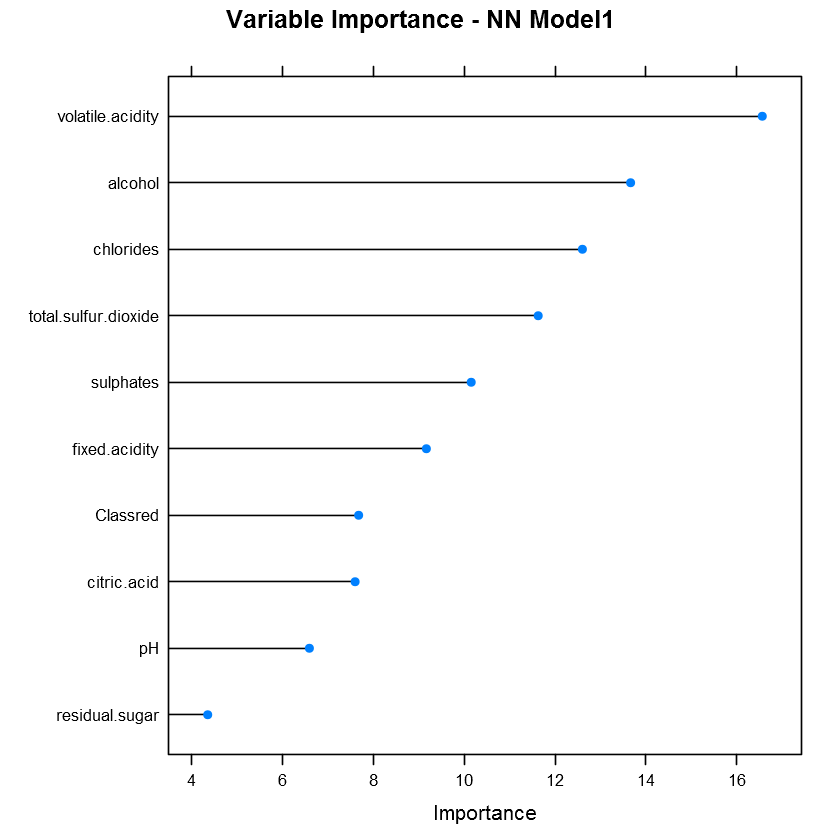

In [26]:
## Graphic variable importance model1
# dev.new()
plot(nn.imp1, top=10, main="Variable Importance - NN Model1")

In [27]:
nnProbs <- predict(model1.fit, testing, type = "prob")
head(nnProbs)

,Bad,Good
1,0.4374785,0.5625215
6,0.5400880,0.4599120
7,0.6498049,0.3501951
11,0.4107859,0.5892141
12,0.6308379,0.3691621
19,0.1536425,0.8463575


Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



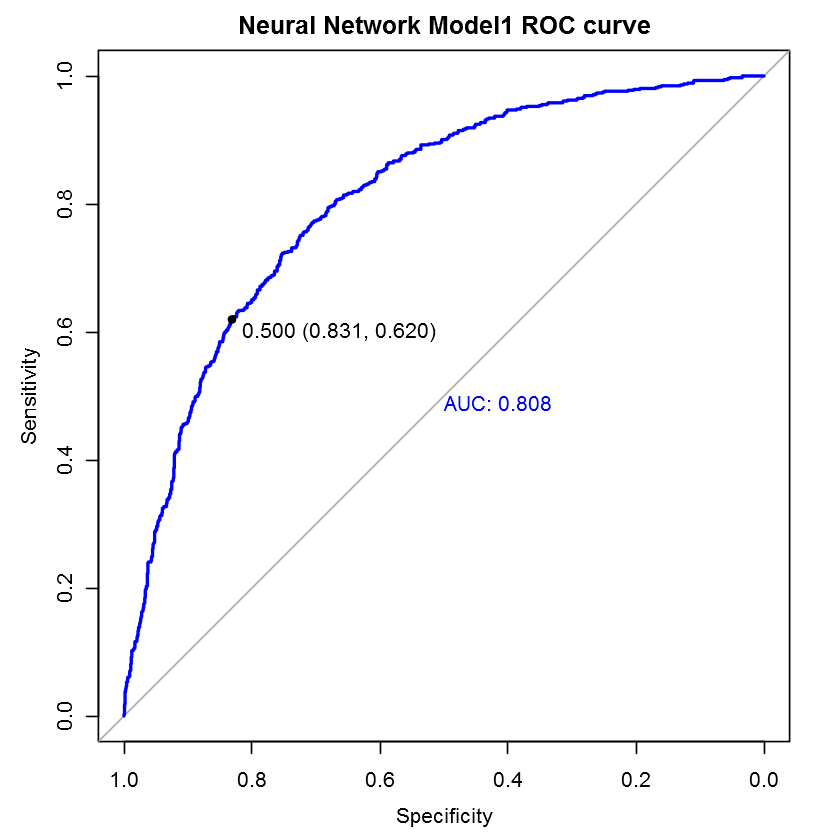

In [28]:
## Creating the ROC Curve
library(pROC)
nnProbs <- predict(model1.fit, testing, type = "prob")
nnROC <- roc(predictor = nnProbs$Good, response = testing$quality, levels = rev(levels(testing$quality)))

plot(nnROC, type = "S", print.thres = .5, main="Neural Network Model1 ROC curve",  col = "blue", print.auc=TRUE)


## 42 Plotting the Neural Network selected model

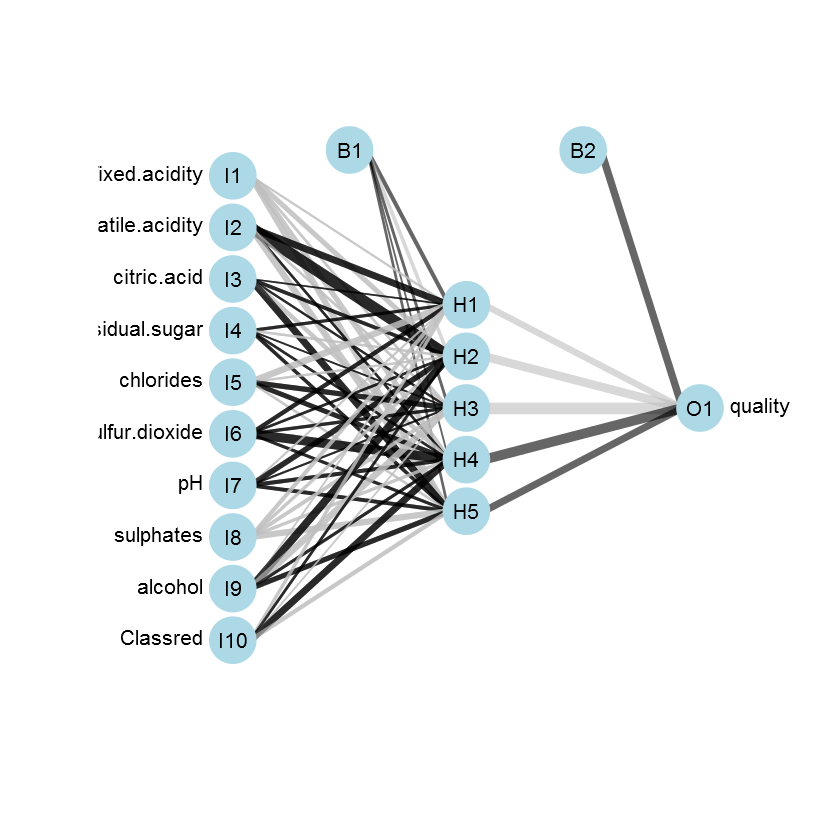

In [29]:
## Creating the nn plot
plotnet(model1.fit, alpha=0.6)


In [30]:
## Getting summary of fitted model1.  We get the weights for the selected nn model
summary(model1.fit)

a 10-5-1 network with 61 weights
options were - entropy fitting  decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   1.73   -0.35    3.53    0.10    1.12   -3.38    1.85   -0.27   -1.64   -0.17 
i10->h1 
  -1.14 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -1.42   -2.29    6.76    1.40   -0.64   -0.49    0.75    2.64   -1.14    4.20 
i10->h2 
   0.79 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   0.94   -0.74   -0.69    0.51    0.11    2.44    1.18    0.38   -1.52   -3.44 
i10->h3 
  -0.05 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
   0.19   -2.47    0.69   -1.85    0.74    2.21    5.22    1.62   -1.10    1.01 
i10->h4 
   3.60 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9->h5 
   0.76   -2.97   -3.27    3.68    1.28   -0.62    1.05    1.55   -3.08    2.42 
i10->h5 
  -1.78 
 b->o h1->o h2->o h3->o h

The model chosen by the nnet method has 5 hidden layer nodes and a decay parameter of 0.1. The nnet plot shows us its graphical representation. 

The weights measures for each combination of input-layer hidden-layer and the output can be gotten from the output of the summary (model1.fit) command.

## V Making predictions
 
After doing all the building stuff, we want to get the predictions from model1 on our training dataset.

In [31]:
# print predictions probabilities by row model1
head(as.data.frame(nnProbs),5)

,Bad,Good
1,0.4374785,0.5625215
6,0.5400880,0.4599120
7,0.6498049,0.3501951
11,0.4107859,0.5892141
12,0.6308379,0.3691621


In [32]:
# print validation dataset and predictions by row model1
head((val<-as.data.frame(c(testing,as.data.frame(preds_nnet)))),10)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class,preds_nnet
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white,Good
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white,Bad
6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,Good,white,Bad
8.1,0.27,0.41,1.45,0.033,63,2.99,0.56,12.0,Bad,white,Good
8.6,0.23,0.40,4.20,0.035,109,3.14,0.53,9.7,Bad,white,Bad
7.4,0.34,0.42,1.10,0.033,171,3.12,0.53,11.3,Good,white,Good
6.5,0.31,0.14,7.50,0.044,133,3.22,0.50,9.5,Bad,white,Bad
7.0,0.25,0.32,9.00,0.046,245,3.25,0.50,10.4,Good,white,Good
7.4,0.27,0.48,1.10,0.047,132,3.19,0.49,11.6,Good,white,Good
8.5,0.24,0.39,10.40,0.044,142,3.20,0.53,10.0,Good,white,Good


Now if you want to get the predictions from a new test data, you can see the item 7.4 of my project [MACHINE LEARNING: A comparison of supervised learning algorithms applied to the classification problem with caret R-project library](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Comparison_R_Caret/MLearning_Classification_Comparison_R_Caret.ipynb). 

## VI Conclusion

I used the wine data set from the UCI Machine Learning data repository. The goal is to predict wine quality which can be "Good" or "Bad".

The original data is separated into white and red datasets. I combined them and created one additional variable: "Class" indicating "white" or "red" wine. After that, I re-coded the "quality" variable to indicate scores greater than or equal to 6 (denoted as "Good") or to indicate scores smaller than 6(denoted as "Bad").

This project develops Neural Network algorithm of machine learning to classify the quality of the wine "Good" or "Bad" according to the 12 variables that characterize the wine subject to classification.

Our original dataset is an imbalance one. There are 6497 registers but only 2384 (36.7%) are of the Bad quality. So, I decided using the ROC metric to compare the model's performance.

The database -dfffull- does not consider two variables that appear in the original base. They could generate a problem of multicollinearity in the process of classification. So,  we got rid of them in dfffull. At the same time, <u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>. The application of this rule does not reduce the original data size because it does not eliminate any register. So, dfffull data size is the same as the original "df" (6497).

All the variables showed to have outliers. Some of them had a lot, some had a few. Mostly outliers were on the positive side of distributions.

"dfffull", consider all registers but replace outliers by a "threshold" value which is generated for each variable using the upper limit of its Box-plot.

Other criterions that use information of variables in the dataset to help out us with the outlier problem may reach better solutions here. Anyway, the criterion used to generate the dfffull dataset is still better than eliminating outliers, because at least do not erase the information that lies in the other variables with no outlier presence at that data point.

The fitted model (model1.fit) achieves a good classification metric, reaching ROC measurement of 82.56%. That is, the variables of the "df" database allow discriminating in a good way the quality of wine that they represent.

I re-run the model without the less important predictors (pH and residual.sugar), and I got a ROC= 81.95%.  So, I decided to keep the model the way it was before. Anyway, you can try reducing one predictor at a time and see how the model change in its metrics. 

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | November 04, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]